In [1]:
#https://cyc1am3n.github.io/2018/11/10/classifying_korean_movie_review.html
#https://circle.haus/t/chapter-3/75#3.3.1-konlpy%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-%ED%95%9C%EA%B5%AD%EC%96%B4-%EC%98%81%ED%99%94-%EB%A6%AC%EB%B7%B0-%EA%B0%90%EC%A0%95-%EB%B6%84%EC%84%9D
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_data(filename):
    with open(filename, 'rt',encoding='UTF8' ) as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data

train_data = read_data('../Positive/ratings_train.txt')
test_data = read_data('../Positive/ratings_test.txt')

In [3]:
print(len(train_data))
print(len(train_data[0]))
print(len(test_data))
print(len(test_data[0]))
train_data[:5] # 상위 5개 출력

150000
3
50000
3


[['9976970', '아 더빙.. 진짜 짜증나네요 목소리', '0'],
 ['3819312', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '1'],
 ['10265843', '너무재밓었다그래서보는것을추천한다', '0'],
 ['9045019', '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '0'],
 ['6483659',
  '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
  '1']]

In [4]:
import konlpy
from konlpy.tag import Okt
import json
import os
from pprint import pprint

okt = Okt()
def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

if os.path.isfile('../Positive/raw/train_docs.json'):
    with open('../Positive/raw/train_docs.json',encoding='UTF8') as f:
        train_docs = json.load(f)
    with open('../Positive/raw/test_docs.json',encoding='UTF8') as f:
        test_docs = json.load(f)
else:
    train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]), row[2]) for row in test_data]
    # JSON 파일로 저장
    with open('../Positive/raw/train_docs.json', 'w', encoding='UTF8') as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('../Positive/raw/test_docs.json', 'w', encoding='UTF8') as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

# 예쁘게(?) 출력하기 위해서 pprint 라이브러리 사용
pprint(train_docs[0])


[['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증나다/Adjective',
  '목소리/Noun'],
 '0']


In [5]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2159921


In [6]:
import nltk
text = nltk.Text(tokens, name='NMSC')
print(text)

# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            

# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

<Text: NMSC>
2159921
49895
[('./Punctuation', 67778),
 ('영화/Noun', 50818),
 ('하다/Verb', 41209),
 ('이/Josa', 38540),
 ('보다/Verb', 38538),
 ('의/Josa', 30188),
 ('../Punctuation', 29055),
 ('가/Josa', 26627),
 ('에/Josa', 26468),
 ('을/Josa', 23118)]


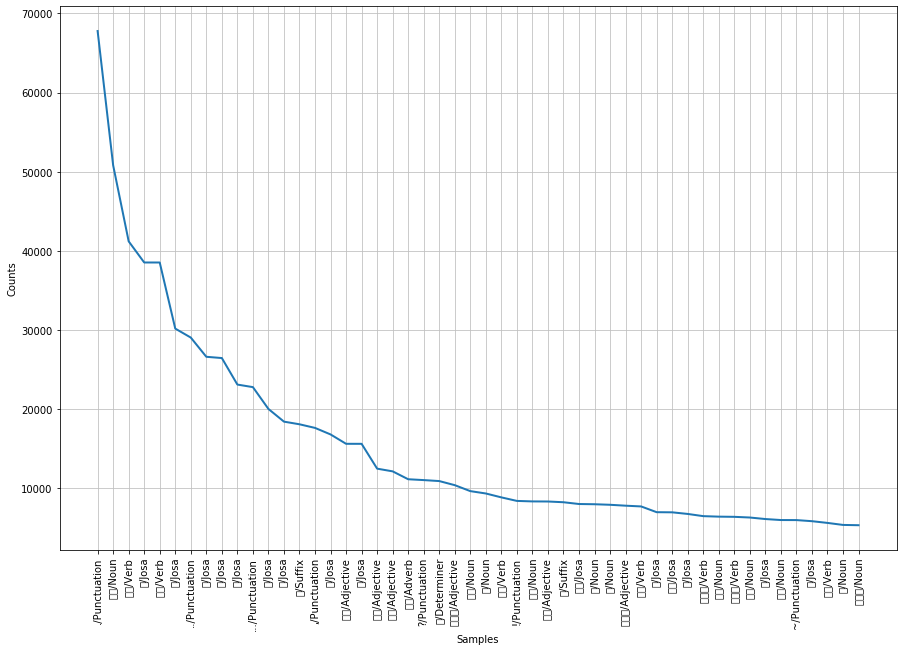

In [7]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

plt.figure(figsize=(15,10))
text.plot(50)

In [13]:
selected_words = [f[0] for f in text.vocab().most_common(1000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

In [14]:
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

from pprint import pprint

pprint(y_train)

array([0., 1., 0., ..., 0., 1., 0.], dtype=float32)


In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(x_train, y_train, epochs=10, batch_size=512)
results = model.evaluate(x_test, y_test)

W0807 14:43:40.227163  7652 deprecation.py:506] From C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0807 14:43:40.315658  7652 deprecation.py:323] From C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
150000/150000 [==============================] - 2s 13us/sample - loss: 0.4333 - binary_accuracy: 0.8025
Epoch 2/10
150000/150000 [==============================] - 2s 11us/sample - loss: 0.3822 - binary_accuracy: 0.8235
Epoch 3/10
150000/150000 [==============================] - 2s 11us/sample - loss: 0.3668 - binary_accuracy: 0.8325
Epoch 4/10
150000/150000 [==============================] - 2s 15us/sample - loss: 0.3538 - binary_accuracy: 0.8401
Epoch 5/10
150000/150000 [==============================] - 2s 16us/sample - loss: 0.3424 - binary_accuracy: 0.8471
Epoch 6/10
150000/150000 [==============================] - 2s 13us/sample - loss: 0.3308 - binary_accuracy: 0.8539
Epoch 7/10
150000/150000 [==============================] - 2s 13us/sample - loss: 0.3194 - binary_accuracy: 0.8597
Epoch 8/10
150000/150000 [==============================] - 2s 13us/sample - loss: 0.3076 - binary_accuracy: 0.8664
Epoch 9/10
150000/150000 [==============================] - 2s 13us/samp

In [11]:
results

[0.39818029284477235, 0.82708]

In [12]:
def predict_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print("[{}]는 {:.2f}% 확률로 긍정적인 답변으로 추측합니다.\n 그리고 점수는 {:.2f} / 10.00 \n".format(review, score * 100, score*10))
    else:
        print("[{}]는 {:.2f}% 확률로 부정적인 답변으로 추측합니다. \n 그리고 점수는 {:.2f} / 10.00 \n".format(review, (1 - score) * 100, score*10))

In [13]:
predict_pos_neg("이건 별로야")
predict_pos_neg("배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.")
predict_pos_neg("주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ")
predict_pos_neg("믿고 보는 감독이지만 이번에는 아니네요")
predict_pos_neg("주연배우 때문에 봤어요")
predict_pos_neg("에라 모르겠다 ㅋ")
predict_pos_neg("응 아니야 ㅋ")

[이건 별로야]는 98.62% 확률로 부정적인 답변으로 추측합니다. 
 그리고 점수는 0.14 / 10.00 

[배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.]는 78.31% 확률로 부정적인 답변으로 추측합니다. 
 그리고 점수는 2.17 / 10.00 

[주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ]는 95.34% 확률로 긍정적인 답변으로 추측합니다.
 그리고 점수는 9.53 / 10.00 

[믿고 보는 감독이지만 이번에는 아니네요]는 68.43% 확률로 부정적인 답변으로 추측합니다. 
 그리고 점수는 3.16 / 10.00 

[주연배우 때문에 봤어요]는 67.73% 확률로 부정적인 답변으로 추측합니다. 
 그리고 점수는 3.23 / 10.00 

[에라 모르겠다 ㅋ]는 60.29% 확률로 부정적인 답변으로 추측합니다. 
 그리고 점수는 3.97 / 10.00 

[응 아니야 ㅋ]는 74.42% 확률로 부정적인 답변으로 추측합니다. 
 그리고 점수는 2.56 / 10.00 

